In [1]:
import os, sys
repo_root = os.path.abspath("..")
if repo_root not in sys.path:
    sys.path.append(repo_root)

import torch
import importlib
import lpips

import Model.Dataloader as Dataloader
from Model.Dataloader import prep_data_precomputed
from Model.utils import inspect_one
import Model.get_pretrained as get_pretrained
from Model.get_pretrained import get_pretrained_small, get_pretrained_large
from Model.model import backward_sampler
from Model.utils import visualize
import Model.evaluation as evaluation
from Model.evaluation import evaluate_over_loader

Load pre-computed data.pt

In [2]:
file_path = '../Ckpts/Sen2MTC_FULL_3v1_norm.pt'
batch_size = 16

train_loader, val_loader, test_loader = prep_data_precomputed(file_path, batch_size)

Not running in Colab, switching to local data prep instead...
Pre-computed Dataloaders loaded successfully.


In [3]:
for batch in train_loader:
    print(batch['cloudy_seq'].shape)
    print(batch['clean'].shape)
    x = batch['cloudy_seq'][0]
    print(x.mean(), x.std())
    break

torch.Size([16, 3, 4, 128, 128])
torch.Size([16, 4, 128, 128])
tensor(0.1122) tensor(0.5368)


Load pretrained models.

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cloud_enc_pth = '../pretrained/cloud_enc_200e_FullData.pth'
denoiser_pth = '../pretrained/denoiser_200e_FullData.pth'
cloud_encoder, forwarder, denoiser = get_pretrained_large(device=device,
                                                          cloud_enc_pth=cloud_enc_pth,
                                                          denoiser_pth=denoiser_pth)

Pretrained large model loaded successfully.
The model has 5125701 parameters.


Pick the next batch in test loader for backward diffusion demonstration.

In [5]:
cloud_encoder.eval()
denoiser.eval()
batch = next(iter(test_loader))
cloudy_seq = batch['cloudy_seq'].to(device)

x0 = backward_sampler(cloudy_seq=cloudy_seq,
                      cloud_encoder=cloud_encoder,
                      denoiser=denoiser,
                      forwarder=forwarder,
                      num_steps=750)

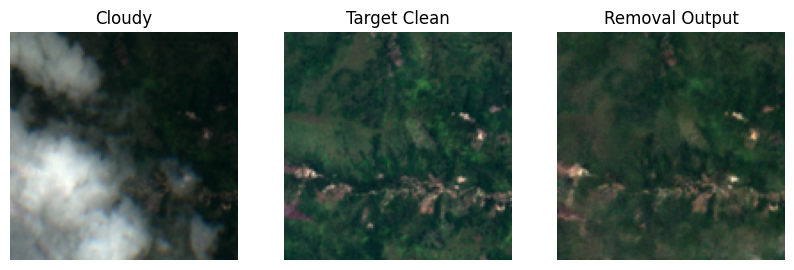

In [6]:
visualize(cloudy_seq=cloudy_seq,
          batch=batch,
          x0=x0)

Evaluate performance on a dataloader.

Calculate `x0` per batch -> evaluate.

In [ ]:
lpips_model = lpips.LPIPS(net='vgg').to(device)
lpips_model.eval()

all_metrics, summary = evaluate_over_loader(
    test_loader=test_loader,
    cloud_encoder=cloud_encoder,
    denoiser=denoiser,
    forwarder=forwarder,
    num_steps=750,
    max_val=1.0,
    lpips_model=lpips_model,
    device=device,
)

print("Per-batch metrics example:", all_metrics[0])
print("Dataset summary:", summary)

